In [ ]:
# 库模块导入
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 加载并规范化CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 超参数1
batch_size = 5

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12432222.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


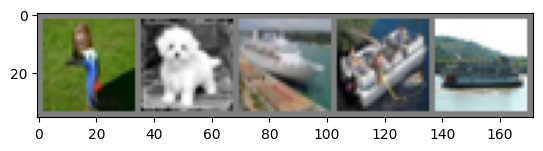

bird  dog   ship  ship  ship 


In [ ]:
# 展示预训练图像

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
# 定义卷积神经网络

# 1.定义VGG网络基本块

"""
# in_channels：输入的通道数，即输入特征图的深度。
# out_channels：输出的通道数，即卷积核的数量，也是输出特征图的深度。
# num_layers：卷积层的数量
"""

def block(in_channels, out_channels, num_layers):
    layers = []
    for i in range(num_layers):
        # 添加卷积层
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
        """
        # kernel_size = 3：卷积核的大小为 3x3
        # padding=1：在输入特征图的四周各填充一行/列的零。
        """
        layers.append(nn.BatchNorm2d(out_channels))
        # 添加ReLU激活函数层
        layers.append(nn.ReLU(inplace=True))
        # 更新输入通道数
        in_channels = out_channels
    # 添加最大池化层
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
    """
    # kernel_size=2: 池化核大小为 2x2
    # stride=2: 池化步幅为 2,将输入特征图的尺寸减半。
    """
    # 封装layers并返回作为基本块的输出
    return nn.Sequential(*layers)


# 2.定义VGG网络

# 使用ImageNet上预训练的VGG16模型构建特征网络
class VGG16(nn.Module):

    # 定义VCC类自身的成员变量
    def __init__(self):
        super(VGG16, self).__init__()

        # 基本块顺序组合成网络结构
        self.layer1 = block(3, 64, 2)
        self.layer2 = block(64, 128, 2)
        self.layer3 = block(128, 256, 3)
        self.layer4 = block(256, 512, 3)
        self.layer5 = block(512, 512, 3)

        # 定义多线性层对经过特征提取的数据进行分类
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Dropout()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
            nn.Dropout()
        )
        self.fc3 = nn.Linear(256, 10)

    #  定义向前传播函数
    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# 创建网络模型
device = torch.device("cuda:0")
net = VGG16()
net = net.to(device)

In [10]:
# 定义绘制loss曲线函数
def DrawLoss(file_name, label_name):

    with open(file_name, 'r') as f:
        raw_data = f.read()
        # [-1:1]是为了去除文件中的前后中括号"[]"
        data = raw_data[1:-1].split(",")

    y_loss = np.asfarray(data, float)
    x_loss = range(len(y_loss))
    plt.figure()

    # 去除顶部和右侧边框
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('iters')    # x轴标签
    plt.ylabel('loss')     # y轴标签

    # 以x_loss为横坐标，y_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
    # 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
    plt.plot(x_loss, y_loss, linewidth=1, linestyle="solid", label=label_name)
    plt.legend()
    plt.title('Loss curve')
    plt.show()


In [18]:
# 定义损失函数和优化器
import torch.optim as optim

# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 超参数2
learning_rate = 0.001

# 使用优化器
# 超参数3
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [21]:
# 训练网络

# 记录训练loss
train_loss = []
# 开始训练
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            train_loss.append(running_loss/100)
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.302
[1,   200] loss: 2.304
[1,   300] loss: 2.304
[1,   400] loss: 2.303
[1,   500] loss: 2.302
[1,   600] loss: 2.304
[1,   700] loss: 2.302
[1,   800] loss: 2.305
[1,   900] loss: 2.303
[1,  1000] loss: 2.301
[1,  1100] loss: 2.303
[1,  1200] loss: 2.305
[1,  1300] loss: 2.303
[1,  1400] loss: 2.304
[1,  1500] loss: 2.303
[1,  1600] loss: 2.303
[1,  1700] loss: 2.300
[1,  1800] loss: 2.301
[1,  1900] loss: 2.302
[1,  2000] loss: 2.305
[1,  2100] loss: 2.304
[1,  2200] loss: 2.304
[1,  2300] loss: 2.303
[1,  2400] loss: 2.301
[1,  2500] loss: 2.302
[1,  2600] loss: 2.303
[1,  2700] loss: 2.304
[1,  2800] loss: 2.304
[1,  2900] loss: 2.304
[1,  3000] loss: 2.303
[1,  3100] loss: 2.303
[1,  3200] loss: 2.304
[1,  3300] loss: 2.303
[1,  3400] loss: 2.301
[1,  3500] loss: 2.304
[1,  3600] loss: 2.304
[1,  3700] loss: 2.303
[1,  3800] loss: 2.302
[1,  3900] loss: 2.302
[1,  4000] loss: 2.304
[1,  4100] loss: 2.300
[1,  4200] loss: 2.305
[1,  4300] loss: 2.306
[1,  4400] 

[2.3019117879867554, 2.3035603404045104, 2.304467885494232, 2.3025539684295655, 2.301586983203888, 2.304069619178772, 2.3022877311706544, 2.304800114631653, 2.3029493355751036, 2.3009826612472533, 2.303078830242157, 2.3046243596076965, 2.303315725326538, 2.303932132720947, 2.3026389122009276, 2.3030877017974856, 2.2998629307746885, 2.3009022736549376, 2.3023962235450743, 2.3050681567192077, 2.303549952507019, 2.3041237592697144, 2.3028311419486998, 2.3014750599861147, 2.3018322920799257, 2.3031723999977114, 2.3043171119689942, 2.3037656140327454, 2.303795278072357, 2.302849690914154, 2.302645366191864, 2.3038734674453734, 2.3025085735321045, 2.3012179827690122, 2.303828055858612, 2.3037385392189025, 2.3034867525100706, 2.301862905025482, 2.301748342514038, 2.303821427822113, 2.300159056186676, 2.3046364092826845, 2.305627312660217, 2.3027513575553895, 2.3030860900878904, 2.3031697916984557, 2.30190376996994, 2.3030076885223387, 2.304355251789093, 2.3013981986045837, 2.304054501056671, 

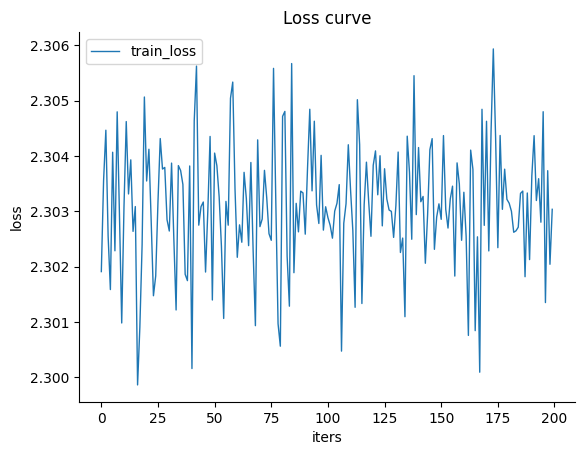

In [22]:
# 绘制train loss曲线
file_name_train = 'train_logs_batch5_lr0.001_opSGD.txt'
with open(file_name_train,'w') as train_los:
    train_los.write(str(train_loss))
print(train_loss)
DrawLoss(file_name_train, "train_loss")

# 新段落

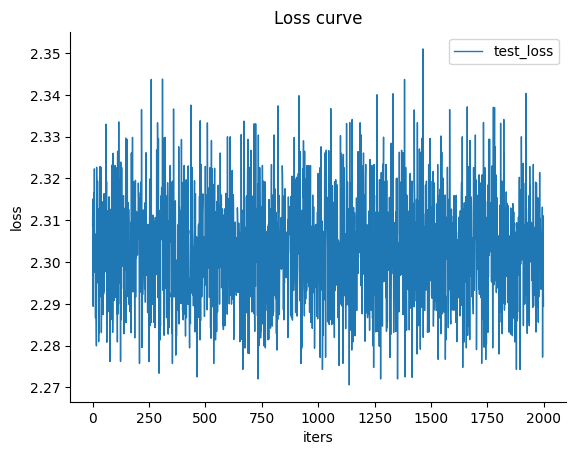

Accuracy of the network on the 10000 test images: 10 %


In [23]:
# 测试网络
correct = 0
total = 0

# 记录测试loss
test_loss = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(images)

        loss = criterion(outputs, labels)
        test_loss.append(loss.item())

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 绘制test loss曲线
file_name_test = 'test_logs_batch5_lr0.001_opSGD.txt'
with open(file_name_test,'w') as test_los:
    test_los.write(str(test_loss))

DrawLoss(file_name_test, "test_loss")


# 整体精度
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')